In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
def read_test_data():
    Dfs = []
    train_df = []
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/test_input_{name}_phase_one.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
        #Dfs.append(df.T.reset_index(drop=True))
    j = 0
    for i in range(0, df.shape[0], 12):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1])]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    return train_df

In [4]:
test_data = read_test_data()

Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24

In [5]:
test_data.shape

(409954, 50)

In [6]:
import joblib

In [7]:
#lgb_model = joblib.load("./trained_models/lgb_model.joblib")
#catb_model = joblib.load("./trained_models/catb_model.joblib")

In [8]:
#y_pred1 = lgb_model.predict(test_data.values)
#y_pred2 = catb_model.predict(test_data.values)

In [9]:
#y_pred = 0.2*y_pred1 + 0.8*y_pred2 ==> -0.06
#y_pred = 0.55*y_pred1 + 0.45*y_pred2 ==> -0.03
#y_pred = 0.8*y_pred1 + 0.2*y_pred2 ==> -0.01
#y_pred = 0.95*y_pred1 + 0.05*y_pred2 ==> -0.0012
#y_pred = 0.99*y_pred1 - 0.01*y_pred2 ==> 0.0032

In [10]:
#y_pred = 0.99*y_pred1 - 0.01*y_pred2

In [11]:
#pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [12]:
#pred_df

In [13]:
#pred_df.to_csv("./predictions.csv", index=False, header=False)

## K-Fold Predictions

In [14]:
import os
from sklearn.base import BaseEstimator, RegressorMixin

In [15]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, coeffs):
        super().__init__()
        self.estimators = estimators
        self.coeffs = coeffs
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [coeff*estimator.predict(X) for estimator, coeff in zip(self.estimators, self.coeffs)]
        return np.sum(y_preds, axis=0)

In [16]:
def load_boosting_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["catb", "lgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [17]:
boosting_models = load_boosting_models("./kfold_trained2/", 5)
coeffs = [0.08, 0.12, 0.08, 0.12, 0.1, 0.1, 0.1, 0.1, 0.06, 0.14]
assert sum(coeffs) == 1
boosting_models = VotingModel(boosting_models, coeffs)

In [18]:
#print(sum(boosting_models.coeffs))

In [19]:
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [20]:
trained_nn_models = load_trained("./trained_models_nn")

In [21]:
y_pred_boost = boosting_models.predict(test_data.values)
y_pred_gru = average_prediction(test_data.values, trained_nn_models[0::2])
y_pred_lstm = average_prediction(test_data.values, trained_nn_models[1::2])

In [22]:
y_pred_lstm

array([[0.408053  ],
       [0.55129457],
       [0.4076072 ],
       ...,
       [0.21938394],
       [0.18747286],
       [0.5706732 ]], dtype=float32)

In [23]:
y_pred_gru

array([[0.3978323 ],
       [0.5199488 ],
       [0.41578475],
       ...,
       [0.12658595],
       [0.09968101],
       [0.3182867 ]], dtype=float32)

In [24]:
y_pred_boost

array([0.40968827, 0.61033464, 0.50389144, ..., 0.17084486, 0.12769062,
       0.59267193])

In [25]:
y_pred = 0.91*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()

In [26]:
pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [27]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.413519,0.610221,0.499384,0.261020,0.199013,0.194932,0.173647,0.204035,0.173151,0.168073,...,0.024862,-0.002499,0.151940,0.115988,0.048577,0.114184,0.286915,0.133223,0.542846,0.747106
1,-0.452064,-0.495839,-0.472238,-0.467548,-0.600497,-0.517502,-0.423907,-0.365181,-0.319681,-0.393909,...,-0.210361,-0.209763,0.051806,0.154276,0.231007,0.285622,0.324772,0.353552,0.472415,0.868721
2,-0.098479,-0.062061,-0.031402,-0.070501,-0.066312,-0.068666,-0.061480,-0.049271,-0.046419,-0.048812,...,0.032404,0.033227,0.238023,0.295192,0.332893,0.342720,0.420706,0.350446,0.431909,0.386909
3,-0.126822,-0.187531,-0.105933,-0.117853,-0.084037,-0.032493,-0.018411,-0.026380,-0.018053,-0.022163,...,-0.328681,-0.255022,-0.169168,-0.114252,-0.053195,0.030705,-0.072592,-0.096501,0.006179,-0.035856
4,-0.536948,-0.334909,-0.339579,-0.455822,-0.442817,-0.349786,-0.273940,-0.252942,-0.389090,-0.405370,...,-0.449169,-0.482486,-0.279273,-0.134238,-0.017018,0.054762,-0.022953,0.118007,0.331882,0.063182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.519552,0.410995,0.358057,0.223648,0.094411,0.064560,0.083027,0.149745,0.117536,0.122499,...,-0.179646,-0.212669,0.087145,0.206457,0.247627,0.358802,0.381744,0.324395,0.529960,0.348364
67,0.167025,0.197994,0.220118,0.122964,0.086943,0.061327,0.075242,0.071843,0.070730,0.044062,...,-0.142170,-0.062521,0.156058,0.279388,0.314744,0.354872,0.456533,0.264167,0.435926,0.348064
68,-0.247008,-0.236514,-0.240609,-0.267419,-0.228312,-0.291850,-0.229150,-0.173707,-0.200420,-0.167777,...,0.431649,0.433571,0.556033,0.574702,0.478248,0.468813,0.741000,0.602561,0.687212,0.458889
69,0.040434,-0.021600,0.059565,0.044246,0.041899,0.040521,0.044695,0.038863,0.029103,0.000747,...,-0.109956,-0.048006,0.315147,0.347591,0.362124,0.303917,0.348851,0.132392,0.240881,-0.080829


In [28]:
pred_df.to_csv("./predictions.csv", index=False, header=False)

In [30]:
best_sub = pd.read_csv(f"./submissions/predictions7.zip", header=None)

['predictions1.zip', 'predictions10.zip', 'predictions11.zip', 'predictions2.zip', 'predictions3.zip', 'predictions4.zip', 'predictions5.zip', 'predictions6.zip', 'predictions7.zip', 'predictions8.zip', 'predictions9.zip']


In [31]:
best_sub

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.415247,0.609742,0.503264,0.261806,0.197564,0.195448,0.172960,0.203128,0.173025,0.169350,...,0.013491,-0.017725,0.148130,0.114392,0.047298,0.109559,0.283891,0.130067,0.545270,0.747813
1,-0.465346,-0.512959,-0.482990,-0.461780,-0.600697,-0.514868,-0.422448,-0.364278,-0.317668,-0.385797,...,-0.212585,-0.211821,0.061770,0.166970,0.244622,0.302895,0.343881,0.376082,0.495570,0.867060
2,-0.093231,-0.052662,-0.025566,-0.063567,-0.055240,-0.058757,-0.052953,-0.041010,-0.039486,-0.042737,...,0.031812,0.029771,0.231616,0.290782,0.334283,0.345708,0.420514,0.349898,0.430698,0.367511
3,-0.125673,-0.181400,-0.099775,-0.112650,-0.079238,-0.025680,-0.014986,-0.024038,-0.013635,-0.018228,...,-0.326608,-0.252101,-0.159040,-0.105152,-0.047870,0.030378,-0.071861,-0.103369,-0.000931,-0.054199
4,-0.539399,-0.333019,-0.336925,-0.454047,-0.443471,-0.348264,-0.271746,-0.257292,-0.392279,-0.407504,...,-0.447019,-0.482028,-0.278163,-0.130700,-0.012827,0.060881,-0.019398,0.121631,0.336582,0.046348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.517943,0.421148,0.369496,0.234380,0.101029,0.063169,0.079739,0.147141,0.117947,0.125366,...,-0.171049,-0.202178,0.096185,0.216509,0.254911,0.362725,0.379895,0.327691,0.532567,0.330308
67,0.164444,0.206723,0.227935,0.127268,0.089756,0.065262,0.079586,0.076502,0.076574,0.047625,...,-0.149556,-0.066936,0.159253,0.287279,0.325079,0.363594,0.467640,0.277732,0.444255,0.369314
68,-0.262072,-0.247581,-0.248435,-0.269852,-0.228721,-0.287209,-0.229858,-0.175299,-0.198542,-0.172039,...,0.446681,0.447990,0.570705,0.592454,0.493741,0.482713,0.749562,0.619133,0.694273,0.452371
69,0.037581,-0.021504,0.055414,0.042652,0.041550,0.042626,0.047514,0.040171,0.029384,0.003028,...,-0.115120,-0.047807,0.322617,0.357677,0.374283,0.316097,0.362342,0.148207,0.257601,-0.071785


In [32]:
cols = [0, 1003, 273]

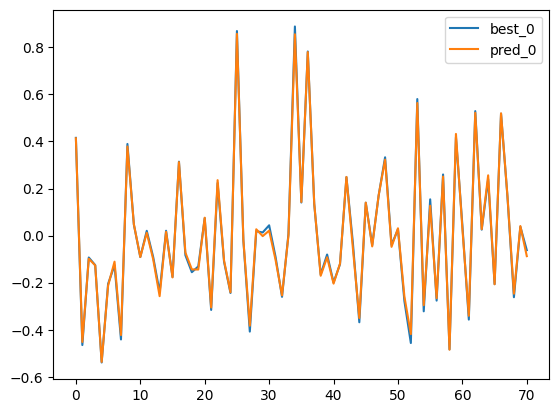

In [33]:
plt.plot(best_sub[cols[0]])
plt.plot(pred_df[cols[0]])

plt.legend([f"best_{cols[0]}", f"pred_{cols[0]}"])
plt.show()

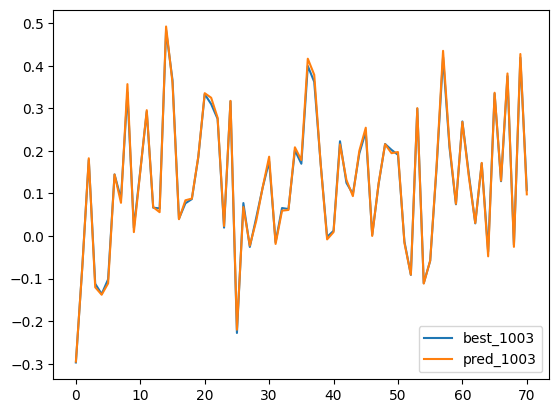

In [34]:
plt.plot(best_sub[cols[1]])
plt.plot(pred_df[cols[1]])

plt.legend([f"best_{cols[1]}", f"pred_{cols[1]}"])
plt.show()

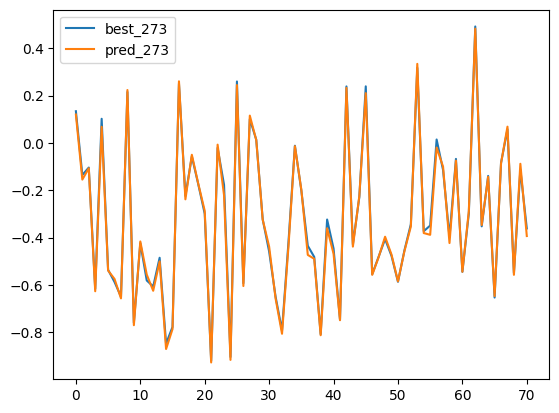

In [35]:
plt.plot(best_sub[cols[2]])
plt.plot(pred_df[cols[2]])

plt.legend([f"best_{cols[2]}", f"pred_{cols[2]}"])
plt.show()

In [36]:
# KFold

# catb 500 estimators, lgbm 1000 estimators
# [0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15] ==> 0.093

# catb and lgb 1000 estimators
# [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] ==> 0.094

# catb and lgb 1000 estimators
# ([0.08, 0.12, 0.08, 0.12, 0.1, 0.1, 0.1, 0.1, 0.06, 0.14])*0.91 + 0.01*gru + 0.09*lstm ==> 0.0951
# y_pred = 0.91*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()